In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1386]:
import folium

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
def is_not_in(dfs):

    unis = [dfs[i]['neighborhood'].unique() for i in range(len(dfs))]

    not_in = []
    for i in range(len(dfs)):
        for j in range(len(dfs)):
        
            if i!=j:
            
                not_in.append([i, j, unis[i][[str(o).lower().strip().replace('á','a')
                                              .replace('é','e')
                                              .replace('í','i')
                                              .replace('ó','o')
                                              .replace('ú','u') not in [str(l).lower().strip().replace('á','a')
                                                                         .replace('é','e')
                                                                         .replace('í','i')
                                                                         .replace('ó','o')
                                                                         .replace('ú','u') for l in unis[j].tolist()] for o in unis[i].tolist()]]])

    return not_in
            

In [4]:
def plot_map(df, zoom=10):
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start = zoom, width='50%', height='50%')


    for lat, lng, label in zip(df['lat'], df['lng'], df.iloc[:, 0]):
    
        #label = folium.Popup(label, html_parser=True)
        folium.CircleMarker([lat, lng],
                            #popup=label,
                            radius=3,
                            color='darkred',
                            #fill=True,
                            #fill_color='blue',
                            #fill_oppacity=0.8
                           ).add_to(mapa)
    return mapa

# Planning

### Data: 
    1. Foursquare Gyms
    2. População alvo (População)
    3. Area
    4. Renda Nominal media mensal ou massa salarial total (Renda)
    5. Estabelecimentos de industrias selecionadas (Comercio)
    6. Consumo de energia comercial e unidades (Comercio)    
    7. Empregados por setor (renda/comercio)
    
### Anaylsis: 
    1. Clustering or thresholds to maximize or minimize 
    2. Regression or classification to understand what drives number of gyms

### Methodology:
    1. First divide neighborhoods by comerce, income and target population
    2. Finaly, divide by gym competition.

# Loading Data

### 1. Foursquare Gyms

In [356]:
gyms = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Search Results\\gyms\\gym_search.csv')

### 2. População alvo (População)

In [357]:
pop3 = pd.read_excel('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Outside Data/raw/bairros/economia/Old/Raw/pop_3.xls', None)

### 3. Area

In [358]:
hoods = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Outside Data/Clean/complete_bairros_fixed.csv')

In [359]:
hoods_limits = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Outside Data\\raw\\bairros\\infraestrutura\\Limite_de_Bairros.csv')

### 4. Renda Nominal media mensal ou massa salarial total (Renda)

In [360]:
income_indv = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Outside Data/raw/bairros/economia/New/clean/rend_nomi/rend_nomi_10oumais_2010.csv')

In [361]:
income_resp = pd.read_excel('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Outside Data/raw/bairros/economia/New/clean/rend_nomi/rend_nomi_mensal_do_resp_domi_part_00_10.xlsx', None)

In [362]:
sal = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Outside Data/raw/bairros/economia/New/clean/atividades economicas/massa_sal_2018.csv')

### 5. Estabelecimentos de industrias selecionadas (Comercio)

In [363]:
stab = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Outside Data/raw/bairros/economia/New/clean/atividades economicas/estabs_2018.csv')

### 6. Consumo de energia (Comercio)    

In [364]:
energy_consump = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Outside Data\\raw\\bairros\\infraestrutura\\clean\\energia_consumo_classe_2018.csv')

In [365]:
energy_units = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Outside Data\\raw\\bairros\\infraestrutura\\clean\\energia_unidades_classe_2017.csv')

### 7. Empregados por setor

In [366]:
emp = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Outside Data\\raw\\bairros\\economia\\New\\clean\\atividades economicas\\empregados_2018.csv')

# Data Cleaning

### 2. População alvo (População)

In [367]:
pop3 = pop3['2010']

In [368]:
pop3_cols = list(pop3.iloc[3, 0:2]) + list(pop3.iloc[5, 2:])
pop3_cols = [i.strip() for i in pop3_cols]
pop3.columns = pop3_cols
pop3 = pop3.tail(-7).head(-3)
pop3 = pop3.dropna(how='all')
pop3.reset_index(drop=True, inplace=True)
pop3.rename(columns={pop3.columns[0]:'neighborhood'}, inplace=True)

In [369]:
pop3.iloc[:, 0] = [neighborhood.lower().strip().replace('á','a')
                   .replace('é','e')
                   .replace('í','i')
                   .replace('ó','o')
                   .replace('ú','u') for neighborhood in pop3.iloc[:, 0]]

In [370]:
pop3.rename(columns={'Total':'População'}, inplace=True)

In [371]:
pop3.shape

(199, 31)

In [372]:
pop3['neighborhood'].unique().size

198

### 3. Area

In [373]:
areas = hoods_limits[['NOME', 'Área']].copy()

In [374]:
areas.columns = ['neighborhood', 'm2']

In [375]:
areas.dropna(inplace=True)

In [376]:
areas['neighborhood'] = [neighborhood.lower().strip().replace('á','a')
                                              .replace('é','e')
                                              .replace('í','i')
                                              .replace('ó','o')
                                              .replace('ú','u') for neighborhood in areas['neighborhood']]

In [377]:
areas.reset_index(drop=True, inplace=True)

In [378]:
areas.shape

(163, 2)

In [379]:
areas['neighborhood'].unique().size

163

### 4. Renda Nominal media mensal ou massa salarial total (Renda)

#### Average and median nominal income of people from 10 years old on, by neighborhood.

In [380]:
income_indv = income_indv.dropna(how='all')

In [381]:
income_indv.rename(columns={income_indv.columns[0]:'neighborhood'}, inplace=True)

In [382]:
income_indv['neighborhood'] = [neighborhood.lower().strip().replace('á','a')
                                              .replace('é','e')
                                              .replace('í','i')
                                              .replace('ó','o')
                                              .replace('ú','u') for neighborhood in income_indv['neighborhood']]

In [383]:
income_indv.reset_index(drop=True, inplace=True)

In [384]:
income_indv.shape

(199, 5)

119, 158 - freguesias

#### Total, average and median monthly nominal income of people responsible for their residences.

In [385]:
income_resp = income_resp['2010']

In [386]:
income_resp.dropna(how='all', inplace=True)

In [387]:
income_resp.rename(columns={income_resp.columns[0]:'neighborhood'}, inplace=True)

In [388]:
income_resp['neighborhood'] = [neighborhood.lower().strip().replace('á','a')
                                              .replace('é','e')
                                              .replace('í','i')
                                              .replace('ó','o')
                                              .replace('ú','u') for neighborhood in income_resp['neighborhood']]

In [389]:
income_resp.reset_index(drop=True, inplace=True)

In [390]:
income_resp.shape

(199, 6)

118,156 - freguesias

#### Mass Salary by industry and neighborhood

In [391]:
sal.rename(columns={'Bairros':'neighborhood'}, inplace=True)

In [392]:
sal.dropna(how='all', subset=['neighborhood'], inplace=True)

In [393]:
sal['neighborhood'] = [neighborhood.lower().strip().replace('á','a')
                                              .replace('é','e')
                                              .replace('í','i')
                                              .replace('ó','o')
                                              .replace('ú','u') for neighborhood in sal['neighborhood']]

In [394]:
sal.reset_index(drop=True, inplace=True)

In [395]:
sal.shape

(215, 28)

### 5. Estabelecimentos de industrias selecionadas (Comercio)

In [396]:
stab.rename(columns={stab.columns[0]:'neighborhood'}, inplace=True)

In [397]:
stab.dropna(how='all', subset=['neighborhood'], inplace=True)

In [398]:
stab['neighborhood'] = [neighborhood.lower().strip().replace('á','a')
                                              .replace('é','e')
                                              .replace('í','i')
                                              .replace('ó','o')
                                              .replace('ú','u') for neighborhood in stab['neighborhood']]

In [399]:
stab.reset_index(drop=True, inplace=True)

In [400]:
stab.shape

(215, 28)

In [401]:
stab['neighborhood'].unique().size

215

### 6. Consumo de energia (Comercio)    

#### Energy comsumption per consumption class and neighborhood

In [402]:
energy_consump.columns = ['neighborhood']+['Consumo ' + col_name.replace(' (1)', '') for col_name in energy_consump.columns[1:]]

In [403]:
energy_consump.dropna(how='all', subset=['neighborhood'], inplace=True)

In [404]:
energy_consump['neighborhood'] = [neighborhood.lower().strip().replace('á','a')
                                              .replace('é','e')
                                              .replace('í','i')
                                              .replace('ó','o')
                                              .replace('ú','u') for neighborhood in energy_consump['neighborhood']]

In [405]:
energy_consump.reset_index(drop=True, inplace=True)

In [406]:
energy_consump.shape

(216, 10)

In [407]:
energy_consump['neighborhood'].unique().size

216

#### Energy consuming units per consumption class and neighborhood

In [408]:
energy_units.columns = ['neighborhood']+['Unidades - ' + col_name.replace(' (1)', '') for col_name in energy_units.columns[1:]]

In [409]:
energy_units.dropna(how='all', subset=['neighborhood'], inplace=True)

In [410]:
energy_units['neighborhood'] = [neighborhood.lower().strip().replace('á','a')
                                              .replace('é','e')
                                              .replace('í','i')
                                              .replace('ó','o')
                                              .replace('ú','u') for neighborhood in energy_units['neighborhood']]

In [411]:
energy_units.reset_index(drop=True, inplace=True)

In [412]:
energy_units.shape

(216, 10)

In [413]:
energy_units['neighborhood'].unique().size

215

### 7. Empregados por setor

In [414]:
emp.rename(columns={emp.columns[0]:'neighborhood'}, inplace=True)

In [415]:
emp.dropna(how='all', subset=['neighborhood'], inplace=True)

In [416]:
emp['neighborhood'] = [neighborhood.lower().strip().replace('á','a')
                                              .replace('é','e')
                                              .replace('í','i')
                                              .replace('ó','o')
                                              .replace('ú','u') for neighborhood in emp['neighborhood']]

In [417]:
emp.reset_index(drop=True, inplace=True)

In [418]:
emp.shape

(215, 28)

In [419]:
emp['neighborhood'].unique().size

215

### 8. Merging Tables

In [420]:
dfs = [pop3, areas, income_indv, income_resp, sal, stab, energy_consump, energy_units, emp]
dfs = [dfs[i].copy() for i in range(len(dfs))]

In [421]:
[df.shape[0] for df in dfs]

[199, 163, 199, 199, 215, 215, 216, 216, 215]

is_not_in(dfs)

In [422]:
incorrect = ['oswaldo cruz', 'imperial de são cristovão', 'vila cosmos', 'grumari(1)', 'joa(1)', ['freguesia ig', 'freguesia (ilha)'], 'freguesia (jacarepagua)']

correct = ['osvaldo cruz', 'são cristovão', 'vila kosmos', 'grumari', 'joa', 'freguesia - ilha do governador', 'freguesia - jacarepagua']

In [423]:
for i in range(len(dfs)):
    
    for incorrect_name, correct_name in zip(incorrect, correct):
    
        if len(incorrect_name)!=2:
            
            if incorrect_name in dfs[i]['neighborhood'].tolist():
                
                dfs[i].loc[dfs[i]['neighborhood'].tolist().index(incorrect_name), 'neighborhood'] = correct_name
        
        else:
            
            for name in incorrect_name:
                
                if name in dfs[i]['neighborhood'].tolist():
                
                    dfs[i].loc[dfs[i]['neighborhood'].tolist().index(name), 'neighborhood'] = correct_name
                    

In [424]:
for i in [0, 2, 3]:
    
    dfs[i].loc[115, 'neighborhood'] = correct[-2]
    dfs[i].loc[153, 'neighborhood'] = correct[-1]
    
dfs[6].loc[165, 'neighborhood'] = correct[-1]

dfs[7].loc[149, 'neighborhood'] = correct[-2]
dfs[7].loc[165, 'neighborhood'] = correct[-1]

In [425]:
not_neighborhood = is_not_in(dfs)

In [426]:
not_neighborhood_unique = []

for i in range(len(not_neighborhood)):
    
    not_neighborhood_unique.extend([name for name in not_neighborhood[i][2]])

not_neighborhood_unique = np.unique(not_neighborhood_unique)

In [427]:
for i in range(len(dfs)):

    dfs[i] = dfs[i][~dfs[i]['neighborhood'].isin(not_neighborhood_unique)].copy()
    
    dfs[i].reset_index(drop=True, inplace=True)

#### Excluded Neighborhoods:
1. Jabour
2. Lapa
3. Vila Kennedy

In [428]:
[dfs[i].shape[0] for i in range(len(dfs))]

[160, 160, 160, 160, 160, 160, 160, 160, 160]

In [429]:
for i in range(len(dfs)):
    
    dfs[i] = dfs[i].sort_values(by='neighborhood').copy()

In [430]:
is_equal = []
for i in range(len(dfs)):
    for j in range(len(dfs)):
        
        if i<j:
            
            is_equal.append(dfs[i]['neighborhood'].tolist()==dfs[j]['neighborhood'].tolist())

if np.array(is_equal).all(): print('All neighborhoods columns are exactly the same')

All neighborhoods columns are exactly the same


In [431]:
is_not_in(dfs)

[[0, 1, array([], dtype=object)],
 [0, 2, array([], dtype=object)],
 [0, 3, array([], dtype=object)],
 [0, 4, array([], dtype=object)],
 [0, 5, array([], dtype=object)],
 [0, 6, array([], dtype=object)],
 [0, 7, array([], dtype=object)],
 [0, 8, array([], dtype=object)],
 [1, 0, array([], dtype=object)],
 [1, 2, array([], dtype=object)],
 [1, 3, array([], dtype=object)],
 [1, 4, array([], dtype=object)],
 [1, 5, array([], dtype=object)],
 [1, 6, array([], dtype=object)],
 [1, 7, array([], dtype=object)],
 [1, 8, array([], dtype=object)],
 [2, 0, array([], dtype=object)],
 [2, 1, array([], dtype=object)],
 [2, 3, array([], dtype=object)],
 [2, 4, array([], dtype=object)],
 [2, 5, array([], dtype=object)],
 [2, 6, array([], dtype=object)],
 [2, 7, array([], dtype=object)],
 [2, 8, array([], dtype=object)],
 [3, 0, array([], dtype=object)],
 [3, 1, array([], dtype=object)],
 [3, 2, array([], dtype=object)],
 [3, 4, array([], dtype=object)],
 [3, 5, array([], dtype=object)],
 [3, 6, array(

In [432]:
dfs = [pop3, areas, income_indv, income_resp, sal, stab, energy_consump, energy_units, emp]
dfs = [dfs[i].copy() for i in range(len(dfs))]

# Merging Neighborhood Data

In [433]:
dfs_index = [0,1,2,3,5,8,4,6,7]

In [434]:
for i in range(len(dfs_index)-1):
    
    if i==0:
        
        data = pd.merge(dfs[dfs_index[i]], dfs[dfs_index[i+1]], on='neighborhood')
    else:
        
        data = pd.merge(data, dfs[dfs_index[i+1]], on='neighborhood')

In [435]:
data.shape    # Shape should be (160, 140)

(153, 140)

# Data Cleaning

In [436]:
for col in data.iloc[:, 1:]:
    
    data.loc[:, col] = data.loc[:, col].astype(str).str.replace(' ', '')

In [437]:
data.replace('-', np.nan, inplace=True)

In [438]:
data.replace('#Value!', np.nan, inplace=True)

In [439]:
data.replace('...', np.nan, inplace=True)

In [440]:
data.iloc[:, 1:] = data.iloc[:, 1:].astype(float)

# Saving Loading Merged Neighborhood Data

In [441]:
#data.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Final Data\\neighborhood_data.csv', index=False)

In [33]:
data = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Final Data\\neighborhood_data.csv')

# Foursquare Gym Data

### Cleaning

In [34]:
incorrect = ['oswaldo cruz', 'imperial de são cristovão', 'vila cosmos', 'grumari(1)', 'joa(1)', ['freguesia ig', 'freguesia (ilha)'], 'freguesia (jacarepagua)']

correct = ['osvaldo cruz', 'são cristovão', 'vila kosmos', 'grumari', 'joa', 'freguesia - ilha do governador', 'freguesia - jacarepagua']

In [35]:
gyms = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Search Results\\gyms\\gym_search.csv')

In [36]:
gyms.rename(columns={gyms.columns[0]:'neighborhood'}, inplace=True)

In [37]:
correct_gym_index = [-2, -1, 1, 0, 2]

In [38]:
incorrect_gym = ['freguesia (ilha do governador)', 'freguesia (jacarepaguá)',
        'imperial de são cristóvão', 'oswaldo cruz',
        'vila cosmos']

In [39]:
for gym_hood_name, correct_index in zip(incorrect_gym, correct_gym_index):
    
    gyms.loc[:, 'neighborhood'][gyms['neighborhood']==gym_hood_name] = [correct[correct_index] for times in range(len(gyms[gyms['neighborhood']==gym_hood_name]['neighborhood']))]
    

<ipython-input-39-39a297d828ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gyms.loc[:, 'neighborhood'][gyms['neighborhood']==gym_hood_name] = [correct[correct_index] for times in range(len(gyms[gyms['neighborhood']==gym_hood_name]['neighborhood']))]


In [40]:
gyms['neighborhood'] = [neighborhood.lower().strip().replace('á','a')
                                              .replace('é','e')
                                              .replace('í','i')
                                              .replace('ó','o')
                                              .replace('ú','u') for neighborhood in gyms['neighborhood']]

In [41]:
is_not_in([data, gyms])

[[0,
  1,
  array(['caju', 'cidade nova', 'mangueira', 'vasco da gama', 'paqueta',
         'agua santa', 'são francisco xavier', 'engenheiro leal', 'turiaçu',
         'bancarios', 'monero', 'praia da bandeira', 'zumbi', 'acari',
         'barros filho', 'costa barros', 'jacarezinho', 'gericino',
         'barra de guaratiba'], dtype=object)],
 [1,
  0,
  array(['freguesia - ilha do governador', 'freguesia - jacarepagua',
         'são cristovão', 'jabour', 'lapa', 'osvaldo cruz', 'vila kosmos',
         'vila kennedy'], dtype=object)]]

### Merging foursquare gym and neighborhoods and data

In [42]:
gyms_grp = gyms[['neighborhood', 'name']].groupby('neighborhood', sort=False, as_index=False).count()

In [43]:
gym_data = pd.merge(gyms_grp, data, on='neighborhood')

In [44]:
gym_data.rename(columns={'name':'gyms'}, inplace=True)

In [45]:
gym_data.columns = [col.strip() for col in gym_data.columns]

In [48]:
gym_data.shape   # Shape should be (134, 141)

(134, 141)

In [49]:
is_not_in([data, gym_data])

[[0,
  1,
  array(['caju', 'cidade nova', 'mangueira', 'vasco da gama', 'paqueta',
         'agua santa', 'são francisco xavier', 'engenheiro leal', 'turiaçu',
         'bancarios', 'monero', 'praia da bandeira', 'zumbi', 'acari',
         'barros filho', 'costa barros', 'jacarezinho', 'gericino',
         'barra de guaratiba'], dtype=object)],
 [1, 0, array([], dtype=object)]]

# Feature Engineering

### Target Population and Gyms

In [50]:
gym_data['target pop'] = gym_data.iloc[:, 19:23].sum(axis=1)

gym_data['Km2'] = gym_data['m2'] / 1000000

gym_data['target_pop/Km2'] = gym_data['target pop'] / gym_data['Km2']

gym_data['pop/Km2'] = gym_data['População'] / gym_data['Km2']

gym_data['gym/Km2'] = gym_data['gyms'] / gym_data['Km2']

gym_data['gym/pop'] = gym_data['gyms'] / gym_data['População']*10000

gym_data['gym/target_pop'] = gym_data['gyms'] / gym_data['target pop']*10000

In [51]:
gym_data.shape     # Shape should be (139, 148)

(134, 148)

### Industries

In [52]:
gym_data['avg salary'] = gym_data['Total'] / gym_data['Total_y']

# Saving Loading Complete Dataframe for Analysis

In [54]:
#gym_data.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Final Data\\gym_neighborhood_data.csv', index=False)

In [55]:
gym_data = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Final Data\\gym_neighborhood_data.csv')

In [56]:
gym_data.shape

(134, 149)

# Target and Predictors Definition

In [31]:
eng_features = gym_data.columns[-7:].tolist()

In [32]:
eng_features.remove('Km2')

In [33]:
targets = ['gyms', 'gym/Km2', 'gym/pop', 'gym/target_pop']

In [34]:
features = [col for col in gym_data.columns if col not in targets and col!='neighborhood']

In [35]:
corr_features = gym_data.corr()[targets[0]][gym_data.corr()[targets[0]]>0.5].index

In [36]:
corr_features.size

42

# Correlation Heatmap

In [ ]:
fig, ax0 = plt.subplots(1,1,figsize=(6, 34))

sns.heatmap(gym_data.corr()[targets], cmap='RdBu', annot=True)

# Variables for Regression

In [38]:
y = gym_data[[targets[0]]].copy()

In [39]:
x = gym_data[features].fillna(0).copy()

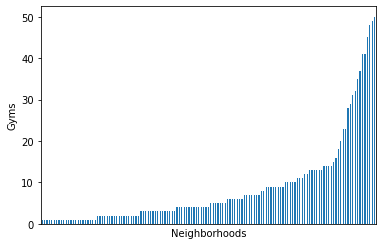

In [40]:
y.iloc[:,0].sort_values().plot.bar(xticks=[])
plt.xlabel('Neighborhoods')
plt.ylabel('Gyms')
plt.show()

# Data Transformation

In [41]:
x_log = x.apply(np.log1p)

In [57]:
y_log = y.apply(np.log1p)

In [42]:
from sklearn.preprocessing import StandardScaler as ss

In [43]:
x_ss = ss().fit_transform(x_log)

# LassoCV Regression

In [44]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

In [131]:
scrs = []

for i in range(150):
    
    msk = np.random.rand(len(y))<0.78
    y_train, y_test = y[msk], y[~msk]
    x_train, x_test = x_ss[msk], x_ss[~msk]

    
    lasso_cv = LassoCV(max_iter=40000).fit(x_train, y_train.values.ravel())
    
    y_pred = lasso_cv.predict(x_test)

    scrs.append([i, lasso_cv.alpha_, r2_score(y_test, y_pred), msk])
    
    if i in range(0, 151, 15): print(i)

scrs = pd.DataFrame(scrs, columns=['i', 'alpha', 'r2', 'msk'])

0
15
30
45
60
75
90
105
120
135


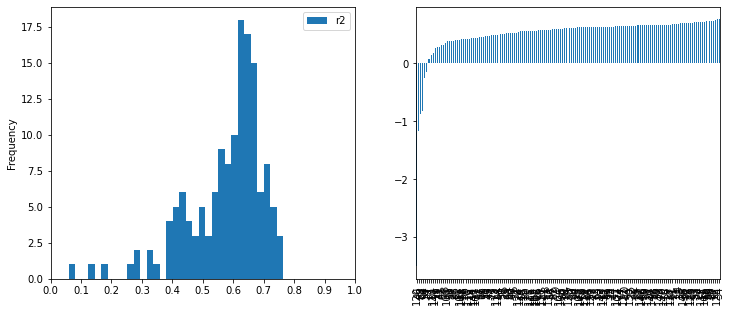

In [139]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,5))

scrs.plot.hist(y='r2', xticks=np.linspace(0,1,11), bins=200, ax=ax0, xlim=(0))
scrs['r2'].sort_values().plot.bar(ax=ax1, xticks=[])

In [140]:
scrs[scrs['r2']==scrs['r2'].max()]

,i,alpha,r2,msk
34,34,0.939462,0.764338,"[True, False, True, True, False, True, False, ..."


# Evaluation

In [141]:
msk = scrs[scrs['r2']==scrs['r2'].max()]['msk'].values[0]

y_train, y_test = y[msk], y[~msk]
x_train, x_test = x_ss[msk], x_ss[~msk]

In [142]:
lasso_cv = LassoCV(max_iter=40000).fit(x_train, y_train.values.ravel())
    

In [143]:
y_pred_tst = lasso_cv.predict(x_test)
y_pred_trn = lasso_cv.predict(x_train)

scrs_lst = [r2_score(y_test, y_pred_tst), r2_score(y_train, y_pred_trn)]
print('Test Set Score:', scrs_lst[0])
print('Train Set Score:', scrs_lst[1])

Test Set Score: 0.7643382083175556
Train Set Score: 0.7178470725296215


Text(0.5, 1.0, 'Train Set Predictions')

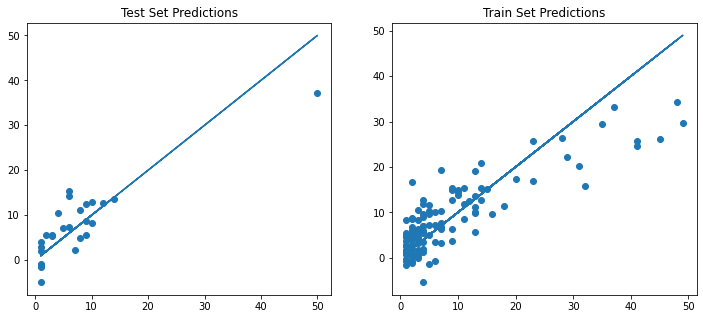

In [144]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].scatter(y_test, y_pred_tst)
axes[0].plot(y_test, y_test)
axes[0].set_title('Test Set Predictions')

axes[1].scatter(y_train, y_pred_trn)
axes[1].plot(y_train, y_train)
axes[1].set_title('Train Set Predictions')

# Feature Selection

In [145]:
selected_cols = []
for coef, col in zip(lasso_cv.coef_, x.columns):

    if coef*1!=0:
        selected_cols.append([col, coef])
        
selected_cols = pd.DataFrame(selected_cols, columns=['feature', 'coef'])

In [146]:
in_corr = []
for neighborhood in selected_cols['feature']:
    
    in_corr.append(neighborhood in corr_features)

In [147]:
selected_cols.sort_values(by='coef', ascending=False)

,feature,coef
1,Valor do rendimento total mensal das pessoas c...,3.908803
5,"Instituições de crédito, seguros e capitalizaç...",1.549582
8,"Agricultura, silvicultura, criação de animais,...",1.108913
12,Consumo Iluminacão pública,0.900251
7,"Serviços médicos, odontológicos e veterinários_x",0.535960
2,Extrativa mineral_x,0.505471
4,Construção civil_x,0.489500
0,Rendimento nominal médio (R$ - exclui sem rend...,0.487147
6,"Comércio e administração de imóveis, valores m...",0.436606
11,Consumo Rural,0.390096


In [148]:
selected_cols[[(not i) for i in in_corr]]

,feature,coef
0,Rendimento nominal médio (R$ - exclui sem rend...,0.487147
5,"Instituições de crédito, seguros e capitalizaç...",1.549582
8,"Agricultura, silvicultura, criação de animais,...",1.108913
9,Minerais não-metálicos_y,-0.151522
10,Indústria de calçados_y,0.053088
12,Consumo Iluminacão pública,0.900251


In [149]:
selected_cols[in_corr]

,feature,coef
1,Valor do rendimento total mensal das pessoas c...,3.908803
2,Extrativa mineral_x,0.505471
3,"Indústria da borracha, fumo, couros, peles, si...",0.310463
4,Construção civil_x,0.489500
6,"Comércio e administração de imóveis, valores m...",0.436606
7,"Serviços médicos, odontológicos e veterinários_x",0.535960
11,Consumo Rural,0.390096


In [150]:
gym_data.corr()[targets[0]][selected_cols[[(not i) for i in in_corr]]['feature'].tolist()]

Rendimento nominal médio (R$ - exclui sem rendimento)                    0.485186
Instituições de crédito, seguros e capitalização_x                       0.432790
Agricultura, silvicultura, criação de animais, extrativismo vegetal_x    0.367096
Minerais não-metálicos_y                                                 0.389723
Indústria de calçados_y                                                 -0.273101
Consumo Iluminacão pública                                               0.340339
Name: gyms, dtype: float64

# Second Degree

In [151]:
from sklearn.preprocessing import PolynomialFeatures as pf

In [152]:
x_pf = pf(degree=2).fit_transform(x_ss)

In [153]:
msk = scrs[scrs['r2']==scrs['r2'].max()]['msk'].values[0]

y_train, y_test = y[msk], y[~msk]
x_train, x_test = x_pf[msk], x_pf[~msk]

In [154]:
lasso_cv = LassoCV(max_iter=40000).fit(x_train, y_train.values.ravel())
  

In [155]:
sum(lasso_cv.coef_>0)

22

# Evaluation

In [156]:
y_pred_tst = lasso_cv.predict(x_test)
y_pred_trn = lasso_cv.predict(x_train)

scrs_lst = [r2_score(y_test, y_pred_tst), r2_score(y_train, y_pred_trn)]

In [157]:
print('Test Set Score:', scrs_lst[0])
print('Train Set Score:', scrs_lst[1])

Test Set Score: 0.8203037332978338
Train Set Score: 0.9172289038841381


Text(0.5, 1.0, 'Train Set Predictions')

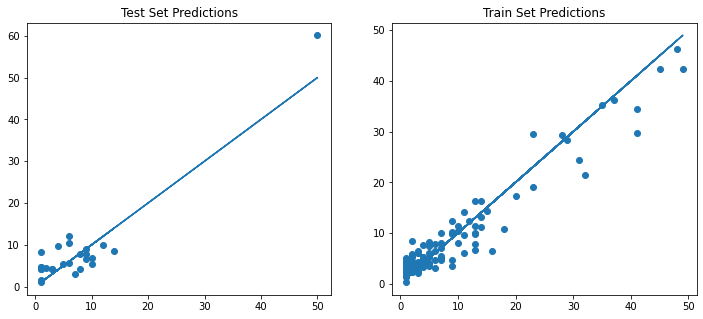

In [158]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].scatter(y_test, y_pred_tst)
axes[0].plot(y_test, y_test)
axes[0].set_title('Test Set Predictions')

axes[1].scatter(y_train, y_pred_trn)
axes[1].plot(y_train, y_train)
axes[1].set_title('Train Set Predictions')

# Second Degree: Top Splits

In [159]:
x_pf = pf(degree=2).fit_transform(x_ss)

In [160]:
scrs_d2 = []

for i in range(7):

    msk = scrs[scrs['r2']==scrs['r2'].sort_values(ascending=False).values[i]]['msk'].values[0]
    y_train, y_test = y[msk], y[~msk]
    x_train, x_test = x_pf[msk], x_pf[~msk]

    lasso_cv = LassoCV(max_iter=40000).fit(x_train, y_train.values.ravel())
    
    y_pred_tst = lasso_cv.predict(x_test)
    y_pred_trn = lasso_cv.predict(x_train)
    
    test_scr = r2_score(y_test, y_pred_tst)
    train_scr = r2_score(y_train, y_pred_trn)
    
    
    scrs_d2.append([i, lasso_cv.alpha_, test_scr, train_scr, msk])
    
    if i in range(7): print(i)

scrs_d2 = pd.DataFrame(scrs_d2, columns=['i', 'alpha', 'r2_test', 'r2_train', 'msk'])


0
1
2
3
4
5
6


# Top Splits Evaluation

In [161]:
msk = scrs_d2[scrs_d2['r2_test']==scrs_d2['r2_test'].max()]['msk'].values[0]

y_train, y_test = y[msk], y[~msk]
x_train, x_test = x_pf[msk], x_pf[~msk]

In [162]:
lasso_cv = LassoCV(max_iter=40000).fit(x_train, y_train.values.ravel())
    

In [163]:
y_pred_tst = lasso_cv.predict(x_test)
y_pred_trn = lasso_cv.predict(x_train)

scrs_lst = [r2_score(y_test, y_pred_tst), r2_score(y_train, y_pred_trn)]
print('Test Set Score:', scrs_lst[0])
print('Train Set Score:', scrs_lst[1])

Test Set Score: 0.9027501130563739
Train Set Score: 0.9514110537984707


Text(0.5, 1.0, 'Train Set Predictions')

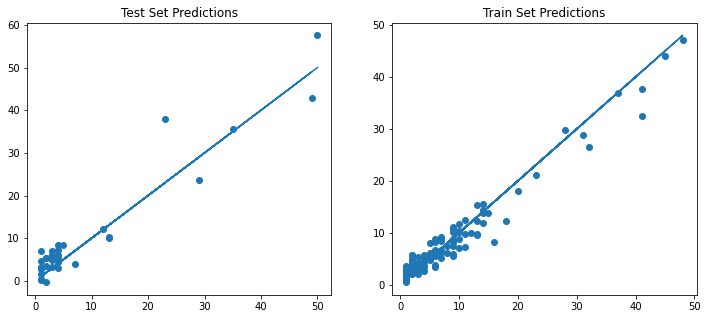

In [164]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].scatter(y_test, y_pred_tst)
axes[0].plot(y_test, y_test)
axes[0].set_title('Test Set Predictions')

axes[1].scatter(y_train, y_pred_trn)
axes[1].plot(y_train, y_train)
axes[1].set_title('Train Set Predictions')